In [14]:
%matplotlib inline

import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [15]:
img = cv2.cvtColor(cv2.imread('Example Photos/portrait-young-woman-with-natural-make-up_23-2149084942.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
XSize = img.shape[0]
YSize = img.shape[1]

In [16]:
imgMask = np.ones((img.shape[0], img.shape[1]), dtype = np.float16) * 1e5
imgIDs = np.ones((img.shape[0], img.shape[1]), dtype = np.int16) * -1

In [17]:
def ColourDistance(c1, c2):
    c1 = c1.astype(np.float16)
    c2 = c2.astype(np.float16)
    dR = (c1[0] - c2[0]) * (c1[0] - c2[0])
    dG = (c1[1] - c2[1]) * (c1[1] - c2[1])
    dB = (c1[2] - c2[2]) * (c1[2] - c2[2])
    hr = (c1[0] + c2[0]) / (2 * 256)
    return ((2 + hr) * dR) + (4 * dG) + ((2 + (255/256) - hr) * dB)

In [18]:
def PositionDistance(P1, P2):
    return (P1[0] - P2[0]) * (P1[0] - P2[0]) + (P1[1] - P2[1]) * (P1[1] - P2[1])

In [19]:
def AddtoAvgCol(avgC, C1, N):
    C1 = C1.astype(np.float64)
    return ((avgC * N)/(N+1)) + (C1  / (N+1))

In [20]:
def AddtoAvgPos(avgP, P1, N):
    return (((avgP[0] * N) + P1[0] ) / (N+1), ((avgP[1] * N) + P1[1] ) / (N+1))

In [21]:
def RemFromAvgCol(avgC, C1, N):
    return (avgC - (C1 / N)) * (N/(N-1))

In [22]:
def RemFromAvgPos(avgP, P1, N):
    return (((avgP[0] - (P1[0] / N)) * (N/(N-1))), ((avgP[1] - (P1[1] / N)) * (N/(N-1))))

In [23]:
Kx = 20
Ky = 30
#THRESHOLD = (Set threshold to a low value, for now i will just repeat steps until a low value is reached)

In [24]:
Sx = (img.shape[0] / (Kx * 2))
Sy = (img.shape[1] / (Ky * 2))

In [25]:
#Make clusters
Clusts = []
pos = (0, 0)
for x in range(Kx):
    pos  = (pos[0] + Sx, 0)
    for y in range(Ky):
        pos  = (pos[0], pos[1] + Sy)
        Approxpos = (int(pos[0]), int(pos[1]))
        Clusts.append((Approxpos, img[Approxpos], 1))
        pos  = (pos[0], pos[1] + Sy)
    pos  = (pos[0] + Sx, 0)

In [26]:
rat = 768 * 768 / (Sx * Sx * Sy * Sy)
for i in range(10):
    for k in range(len(Clusts)):
        C = Clusts[k]
        for x in range(int(max(0, (C[0][0] -  (2 * Sx)))), int(min(XSize, C[0][0] + (2 * Sx)))):
            for y in range(int(max(0, (C[0][1] -  (2 * Sy)))), int(min(YSize, C[0][1] + (2 * Sy)))):
                pos = (x, y)
                ColDis = ColourDistance(C[1], img[pos])
                PosDis = PositionDistance(C[0], pos) * rat
                dis = math.sqrt(ColDis + PosDis)
                if(imgMask[pos] > dis):
                    imgIDs[pos] = k
                    imgMask[pos] = dis
        Clusts[k] = (Clusts[k][0], Clusts[k][1], 0)
    
    for x in range(XSize):
        for y in range(YSize):
            pos = (x, y)
            KVal = imgIDs[pos]
            if(KVal == -1):
                continue
            Clusts[KVal] = (AddtoAvgPos(Clusts[KVal][0], pos, Clusts[KVal][2]),
                            AddtoAvgCol(Clusts[KVal][1], img[pos], Clusts[KVal][2]),
                            Clusts[KVal][2] + 1)
            

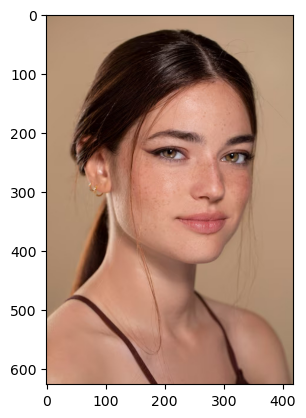

In [27]:
plt.imshow(img)

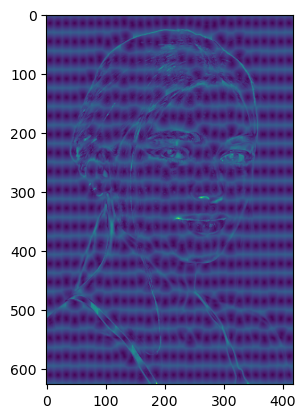

In [28]:
plt.imshow(imgMask)

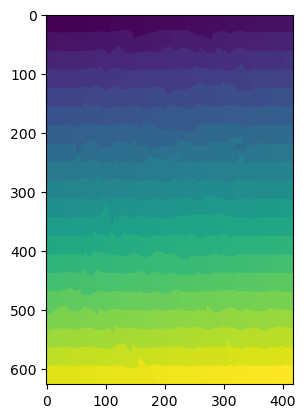

In [29]:
plt.imshow(imgIDs)

In [30]:
imgS = np.zeros(img.shape, dtype = img.dtype)

for x in range(imgIDs.shape[0]):
    for y in range(imgIDs.shape[1]):
        if(imgIDs[(x, y)] == -1):
            continue
        imgS[(x,y)] = Clusts[imgIDs[(x, y)]][1].astype(np.uint8)


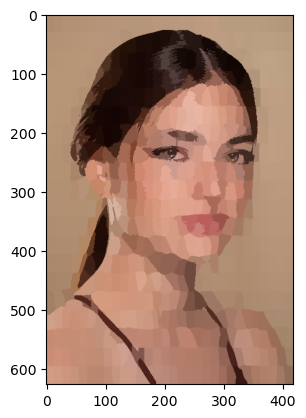

In [31]:
plt.imshow(imgS)

In [32]:
cv2.imwrite('Example Photos/Fin5SLIC.jpg', cv2.cvtColor(imgS, cv2.COLOR_RGB2BGR))

True